In [1]:
import osmnx as ox
import momepy
import geopandas as gpd
import pandas as pd
from blocksnet import City, Centrality
from sklearn.preprocessing import MinMaxScaler
import pickle

/Users/polina/Desktop/road_demand/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Инициализация

In [2]:
city = City.from_pickle('/Users/polina/Desktop/work_folder/model.pickle')

with open("graph.pkl", "rb") as f:
    graph = pickle.load(f)
n,e = momepy.nx_to_gdf(graph)

with open("walk_graph.pkl", "rb") as f:
    G_walk = pickle.load(f)

local_crs = 32636

## Предобработка и извлечение кварталов


In [3]:
blocks = city.get_blocks_gdf()[['land_use','population']]

#calculate density, diversity
centrality = Centrality(city_model=city)
result = centrality.calculate()
blocks = pd.merge(blocks,result,left_index=True, right_index = True)
blocks.loc[blocks['density'].isna(), 'density'] = 0.0
blocks.loc[blocks['diversity'].isna(), 'diversity'] = 0.0
# Normalize the  columns to [0,1] range
scaler = MinMaxScaler()
blocks[["density", "diversity"]] = scaler.fit_transform(
    blocks[["density", "diversity"]]
)

blocks = blocks.set_geometry('geometry')

# cut the needed polygons of the island
polygon = ox.geocode_to_gdf(f'R1114252', by_osmid=True).to_crs(local_crs)
blocks = gpd.overlay(blocks,polygon).copy()
blocks = blocks[['land_use', 'population', 'density', 'diversity',
       'centrality', 'geometry']]

In [4]:
# rules for lu_coeff calculation
landuse_coeff = {
    None: 0.06,
    'industrial': 0.25,
    'business': 0.3,
    'special': 0.1,
    'transport': 0.1,
    'residential': 0.1,
    'agriculture': 0.05,
    'recreation': 0.05
}

# calculate the lu_coeff and attractiveness measures
blocks['lu_coeff'] = blocks['land_use'].apply(lambda x: landuse_coeff.get(x, 0))
blocks['attractiveness'] = blocks['density'] + blocks['diversity'] + blocks['lu_coeff']

## Расчет загруженности

In [5]:
from traffic_congestion import get_OD_mx, get_road_congestion, visualize_congestion

In [6]:
OD_mx = get_OD_mx(blocks, n, G_walk , graph, local_crs)
new_graph = get_road_congestion(OD_mx, graph)

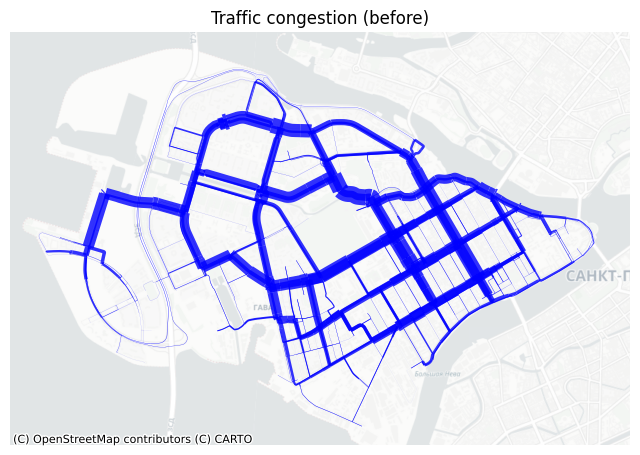

In [7]:
visualize_congestion(new_graph,label="Traffic congestion (before)")

## Cценарий увеличения населения


In [8]:
blocks.at[173,'population'] = blocks.at[173,'population'] *  10

In [9]:
OD_mx2 = get_OD_mx(blocks, n, G_walk , graph, local_crs)
new_graph2 = get_road_congestion(OD_mx2, graph)

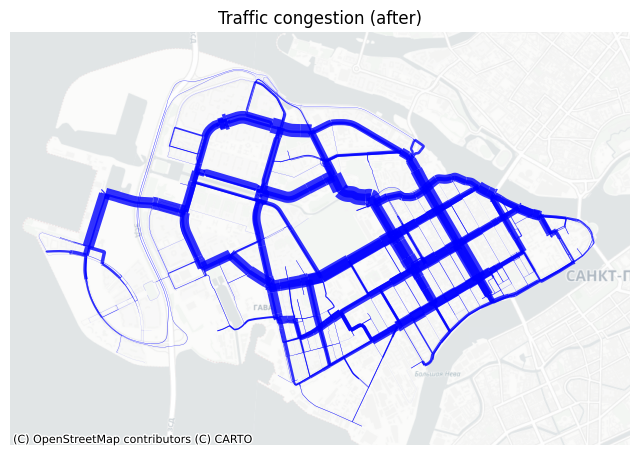

In [10]:
visualize_congestion(new_graph2,label="Traffic congestion (after)")